# Entropic benchmark

This notebook replicates a setting due to [Gushchin et al. (2024](https://arxiv.org/abs/2306.10161). They construct a drift function that transports the standard Gaussian to a high-dimensional distribution with four modes. We start by calling their three (source, target, and ground_truth) samplers. 

In [1]:
import torch
import numpy as np
from sklearn.decomposition import PCA
from tqdm import tqdm
import matplotlib.pyplot as plt

from utils_for_examples import *

# import sys
# sys.path.append("../EntropicOptimalTransportBenchmark")

import eot_benchmark

from eot_benchmark.benchmark.gaussian_mixture_benchmark import (
    get_guassian_mixture_benchmark_sampler,
    get_guassian_mixture_benchmark_ground_truth_sampler, 
    get_test_input_samples,
)
from eot_benchmark.benchmark.metrics import (
    compute_BW_UVP_by_gt_samples, compute_BW_by_gt_samples, calculate_cond_bw
)

plt.rcParams.update({'font.size': 20})


In [2]:
dim = 64  # 2,16,64,128
eps =  1 # 0.1, 1, 10
BATCH_SIZE= 4096
first_time = True # set to "False" if the dim/eps configuration above has already been downloaded

torch.manual_seed(0), np.random.seed(0)

input_sampler = get_guassian_mixture_benchmark_sampler(input_or_target="input", dim=dim, eps=eps,
                                          batch_size=BATCH_SIZE, download=first_time) 

target_sampler = get_guassian_mixture_benchmark_sampler(input_or_target="target", dim=dim, eps=eps,
                                          batch_size=BATCH_SIZE, download=first_time) 

ground_truth_plan_sampler = get_guassian_mixture_benchmark_ground_truth_sampler(dim=dim,eps=eps,
                                                          batch_size=BATCH_SIZE,download=first_time)

Downloading...
From (original): https://drive.google.com/uc?id=1HNXbrkozARbz4r8fdFbjvPw8R74n1oiY
From (redirected): https://drive.google.com/uc?id=1HNXbrkozARbz4r8fdFbjvPw8R74n1oiY&confirm=t&uuid=cbc5adc5-f3f0-46a3-9ed0-b7424336ae03
To: /Users/Viresh/eot_benchmark_data/gaussian_mixture_benchmark_data.zip
100%|██████████| 84.8M/84.8M [00:00<00:00, 106MB/s] 
Downloading...
From (original): https://drive.google.com/uc?id=1HNXbrkozARbz4r8fdFbjvPw8R74n1oiY
From (redirected): https://drive.google.com/uc?id=1HNXbrkozARbz4r8fdFbjvPw8R74n1oiY&confirm=t&uuid=e540151f-9112-410f-bbe0-0b33af1baa68
To: /Users/Viresh/eot_benchmark_data/gaussian_mixture_benchmark_data.zip
100%|██████████| 84.8M/84.8M [00:00<00:00, 110MB/s] 
Downloading...
From (original): https://drive.google.com/uc?id=1HNXbrkozARbz4r8fdFbjvPw8R74n1oiY
From (redirected): https://drive.google.com/uc?id=1HNXbrkozARbz4r8fdFbjvPw8R74n1oiY&confirm=t&uuid=0378d0e6-6f22-4869-9f85-38b257ca1b54
To: /Users/Viresh/eot_benchmark_data/gaussian_mix

Since our algorithm does not apply in the continuous regime, we fix a set of samples from the source and target to be used as our initial data, compute the static potentials, and then define the drift function

In [3]:
Ntrain = int(BATCH_SIZE)

xdata = (input_sampler.sample(Ntrain)).numpy()
ydata = (target_sampler.sample(Ntrain)).numpy()


_,geps_over_eps = sinkhorn_potentials(xdata.T,ydata.T,eps,dim,Ntrain,iters_max=5000)
drift_estimator = ent_drift(ydata,geps_over_eps,eps)


We now draw `Ntest` many samples from the source and target (which are paired), and use them to evaluate the drift. We initialize our drift at the new source samples, and finally compute the BW-UVP on our generated samples and the newly sampled target samples

In [4]:
np.random.seed(42)

Ntest = int(10000)

xtest_th = input_sampler.sample(Ntest)
ytest = ground_truth_plan_sampler.conditional_plan.sample(xtest_th).numpy()
xtest = xtest_th.numpy()

tau = 0.99
Nsteps = 100
dt = tau/Nsteps


In [5]:

def run_simulation(xtest, Nsteps, dt, eps, dim, ydata, geps_over_eps):
    k=0
    t=0.0
    y_sde = xtest.copy()
    drift = ent_drift(ydata,geps_over_eps,eps)
    
    while k < Nsteps:
        bteps_x = drift(y_sde,1-t)
        eta = np.random.multivariate_normal(np.zeros(dim), np.eye(dim), size=xtest.shape[0])
        y_sde += (dt * bteps_x) + np.sqrt(dt * eps)*eta
        k += 1
        t = k*dt
    return y_sde

# Time the function
%timeit y_sde = run_simulation(xtest, Nsteps, dt, eps, dim, ydata, geps_over_eps)

KeyboardInterrupt: 

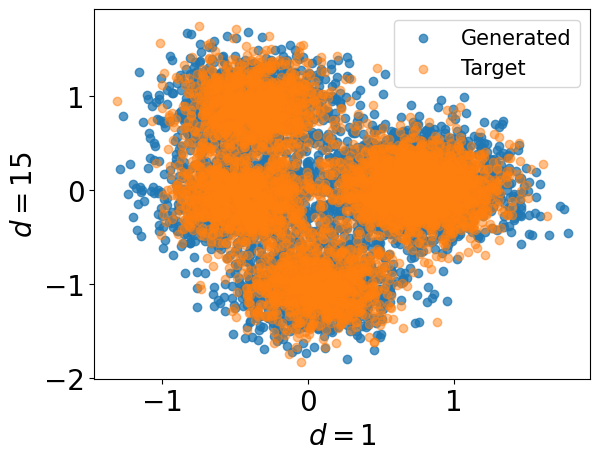

In [6]:
# Cell 3 - Generate final result and plot
np.random.seed(42)  # Reset seed for consistent plot
y_sde = run_simulation(xtest, Nsteps, dt, eps, dim, ydata, geps_over_eps)

plt.scatter(y_sde[0:5000,0],y_sde[0:5000,14],alpha=0.75,label='Generated')
plt.scatter(ytest[0:5000,0],ytest[0:5000,14],alpha=0.5,label='Target')
plt.ylabel(r'$d={15}$')
plt.xlabel(r'$d={1}$')
plt.legend(loc='upper right',fontsize=15)
plt.savefig('gmm_1and15.png',bbox_inches='tight',dpi=300,format='png')

In [8]:
compute_BW_UVP_by_gt_samples(y_sde,ytest)

np.float64(0.3720752022557967)